# Análise de Imagem de Túnel por Setores

Este notebook realiza a análise setorial de uma imagem de túnel, classificando cada setor em proporções de:


🌌 Céu

🛣️ Pavimento

🪨 Rochas

🏢 Edifícios

🌿 Matas

🚇 Túnel

Os resultados são exportados para um CSV.

In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install ipympl


Note: you may need to restart the kernel to use updated packages.


In [5]:
%matplotlib widget


## Depois de confirmar que tudo esteja instalado, comece o programa daqui

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import Dropdown, VBox, FileUpload
from io import BytesIO



In [2]:
# Widget de upload
uploader = widgets.FileUpload(
    accept='image/*',
    multiple=False,
    description="Upload Imagem"
)

uploader

FileUpload(value=(), accept='image/*', description='Upload Imagem')

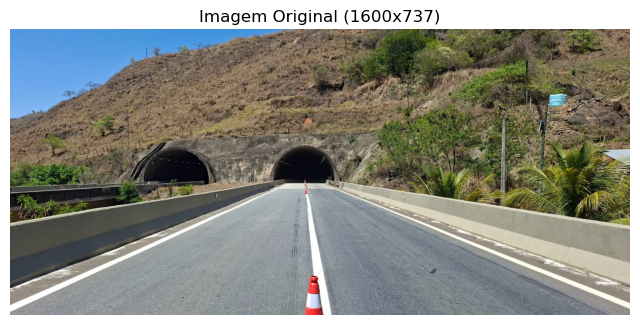

In [4]:
# Pegar o arquivo enviado (compatível com tuple ou dict)
if uploader.value:
    if isinstance(uploader.value, dict):
        # Versão antiga
        nome, arquivo = list(uploader.value.items())[0]
        conteudo = arquivo['content']
    else:
        # Versão nova (tuple/list)
        arquivo = uploader.value[0]
        nome = arquivo['name']
        conteudo = arquivo['content']

    # Converter bytes → numpy array → imagem OpenCV
    bytes_imagem = np.frombuffer(conteudo, np.uint8)
    img = cv2.imdecode(bytes_imagem, cv2.IMREAD_COLOR)  # BGR
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)          # RGB

    h, w, _ = img.shape

    # Mostrar imagem
    plt.figure(figsize=(8,8))
    plt.imshow(img)
    plt.title(f"Imagem Original ({w}x{h})")
    plt.axis("off")
    plt.show()
else:
    print("⚠️ Nenhuma imagem foi enviada ainda.")


# Tratamento de Imagem

HSV é a abreviatura para o sistema de cores formadas pelas componentes hue (matiz), saturation (saturação) e value (valor). O HSV também é conhecido como HSB (hue, saturation e brightness — matiz, saturação e brilho, respectivamente). Esse sistema de cores define o espaço de cor conforme descrito abaixo, utilizando seus três parâmetros:

Matiz (tonalidade): Verifica o tipo de cor, abrangendo todas as cores do espectro, desde o vermelho até o violeta, mais o magenta. Atinge valores de 0 a 360, mas para algumas aplicações, esse valor é normalizado de 0 a 100%.
Saturação: Também chamado de "pureza". Quanto menor esse valor, mais com tom de cinza aparecerá a imagem. Quanto maior o valor, mais "pura" é a imagem. Atinge valores de 0 a 100%.
Valor (brilho): Define o brilho da cor. Atinge valores de 0 a 100%.

True

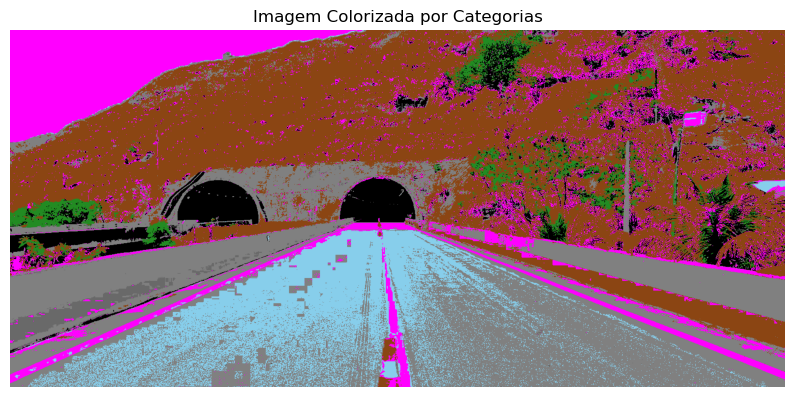

In [5]:
# Dicionário com cores RGB para cada categoria
cores = {
    "ceu": (135, 206, 235),         # azul claro
    "pavimento": (128, 128, 128),   # cinza
    "rochas": (139, 69, 19),        # marrom
    "edificios": (105, 105, 105),   # cinza escuro
    "matas": (34, 139, 34),         # verde
    "tunnel": (0, 0, 0),            # preto
    "desconhecido": (255, 0, 255)   # magenta
}

def classificar_pixel(h, s, v):
    # Céu: tons claros e pouco saturados (azul claro, céu diurno)
    if (h >= 90 and h <= 130) and v > 150 and s < 80:
        return "ceu"
    
    # Pavimento: tons claros de cinza, baixa saturação
    elif 60 <= v < 180 and s < 50:  # ajustado para pegar tons mais claros
        return "pavimento"
    
    # Rochas: tons acastanhados, cinza ou bege
    elif (0 <= h <= 40 or 20 <= h <= 30) and s > 30 and v > 80:
        return "rochas"
    
    # Edifícios: geralmente cinza/escuro, saturação média
    elif s < 60 and 50 < v < 180:
        return "edificios"
    
    # Vegetação/matas: tons de verde
    elif 35 <= h <= 85 and s > 40 and v > 50:
        return "matas"
    
    # Túnel: muito escuro, pouco saturado
    elif v < 50:
        return "tunnel"
    
    else:
        return "desconhecido"

# --- Pipeline de segmentação ---


# Converter para HSV
hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

# Achatar HSV para iterar pixel a pixel
pixels_hsv = hsv_img.reshape(-1, 3)

# Classificar pixels
classes = [classificar_pixel(h, s, v) for h, s, v in pixels_hsv]

# Criar imagem segmentada com as cores
img_colorizada = np.array([cores.get(cls, (255, 0, 255)) for cls in classes], dtype=np.uint8)

# Reshape para tamanho original
img_colorizada = img_colorizada.reshape(img.shape)

# Mostrar resultado e salvar imagem
plt.figure(figsize=(10,10))
plt.imshow(img_colorizada)
plt.title("Imagem Colorizada por Categorias")
plt.axis("off")

# Salvar a figura
cv2.imwrite("imagem_colorizada.png", cv2.cvtColor(img_colorizada, cv2.COLOR_RGB2BGR))


## Após a edição da imagem_colorizada no paint, reinsira o arquivo para gerar os dados tabelados

In [6]:
import ipywidgets as widgets
from IPython.display import display

# Widget de upload
uploader_colorizada = widgets.FileUpload(
    accept='image/*',  # aceitar imagens
    multiple=False,
    description="📂 Upload Imagem Colorizada"
)

# Output para mostrar a imagem
output_colorizada = widgets.Output()

def carregar_colorizada(change):
    output_colorizada.clear_output()
    
    if uploader_colorizada.value:
        # Compatível com tuple/list
        arquivo = uploader_colorizada.value[0]
        nome = arquivo['name']
        conteudo = arquivo['content']
        
        # Mostrar a imagem diretamente como widget.Image
        img_widget = widgets.Image(
            value=conteudo,
            format=nome.split('.')[-1],
            width=400,
            height=400
        )
        
        with output_colorizada:
            display(img_widget)
            
        # Guardar a imagem em memória para processamento futuro
        global img_colorizada_bytes
        img_colorizada_bytes = conteudo

# Conectar evento
uploader_colorizada.observe(carregar_colorizada, names='value')

# Exibir interface
widgets.VBox([uploader_colorizada, output_colorizada])


#  Variaveis para Setorização

### Cálculo de Setores Concêntricos

Para definir setores concêntricos em uma imagem ou planta de túnel, seguimos os seguintes passos:

1. **Escolha dos ângulos**  
   Definimos uma sequência de ângulos em graus que representam a abertura de cada coroa concêntrica a partir do ponto central. Cada ângulo indica a inclinação radial correspondente à distância do túnel.

2. **Conversão para radianos**  
   Como funções trigonométricas (como a tangente) trabalham com radianos, convertemos cada ângulo $\theta$ de graus para radianos:

   $$
   \theta_{\text{rad}} = \theta_{\text{graus}} \cdot \frac{\pi}{180}
   $$

3. **Cálculo dos raios**  
   Para cada ângulo em radianos, calculamos o raio da coroa usando a tangente:

   $$
   r = d \cdot \tan(\theta_{\text{rad}})
   $$

   Onde:  
   - $r$ é o raio da coroa concêntrica na imagem,  
   - $d$ é a distância do ponto central até o túnel,  
   - $\theta_{\text{rad}}$ é o ângulo em radianos.

4. **Formação das coroas concêntricas**  
   Cada valor de raio define a posição de um círculo concêntrico. Entre dois raios consecutivos, forma-se uma “coroa” que pode ser dividida em setores angulares. Cada setor cobre um intervalo de ângulos:

   $$
   \text{Setor } j: \quad \theta_{\text{in}} = \frac{2 \pi j}{N}, \quad 
   \theta_{\text{out}} = \frac{2 \pi (j+1)}{N}
   $$

   Onde $N$ é o número de setores angulares por coroa.

Dessa forma, combinando **raios concêntricos** e **divisões angulares**, obtemos uma malha de setores que cobre toda a área de interesse, útil para segmentação de imagens, análise de iluminação ou estudo de visibilidade


In [62]:
import numpy as np
import cv2
from ipywidgets import interact, IntSlider
from matplotlib import pyplot as plt

# --- Converter imagem do uploader para numpy ---
img_colorizada = bytes_para_cv2(img_colorizada_bytes)

# --- Parâmetros fixos ---
h, w, _ = img_colorizada.shape
h_camera = 2.5         # altura da câmera em metros
altura_tunel = 5.0     # altura real do túnel em metros
distancia_tunel = 90   # distância real até o final do túnel
num_setores  = 12      # divisões angulares

# --- Ângulos e raios em metros ---
angulos_graus = [2.0, 3.0, 4.0, 5.8, 8.0, 11.6, 16.6, 24.0, 36.0, 56.8]
lista_angulos = np.radians(angulos_graus)
lista_raios = [distancia_tunel * np.tan(theta) for theta in lista_angulos]

# --- Função para gerar setores concêntricos e angulares ---
def gerar_setores_conc_ang(h, w, center, lista_raios_pixels, num_setores):
    setores = []
    Y, X = np.ogrid[:h, :w]
    dx, dy = X - center[0], Y - center[1]

    R = np.sqrt(dx**2 + dy**2)
    Theta = (np.arctan2(dy, dx) + 2*np.pi) % (2*np.pi)  # [0, 2pi)

    raio_in = 0
    for raio_out in lista_raios_pixels:
        for j in range(num_setores):
            ang_in = 2 * np.pi * j / num_setores
            ang_out = 2 * np.pi * (j + 1) / num_setores

            mask = (R > raio_in) & (R <= raio_out) & (Theta >= ang_in) & (Theta < ang_out)
            setores.append(mask.astype(np.uint8))
        raio_in = raio_out

    return setores

# --- Função para desenhar setores ---
def desenhar_setores(img, center, lista_raios_pixels, num_setores, cor=(255,0,0), espessura=1):
    img_draw = img.copy()
    # círculos
    for r in lista_raios_pixels:
        cv2.circle(img_draw, center, int(r), cor, espessura)
    # divisões angulares
    for j in range(num_setores):
        ang = 2 * np.pi * j / num_setores
        x_end = int(center[0] + lista_raios_pixels[-1] * np.cos(ang))
        y_end = int(center[1] + lista_raios_pixels[-1] * np.sin(ang))
        cv2.line(img_draw, center, (x_end, y_end), cor, espessura)
    return img_draw

# --- Função principal (com sliders) ---
def atualizar_setores(x_center, y_chao, y_topo):
    # Calcula centro baseado na altura da câmera
    y_center = int(y_chao - (h_camera / altura_tunel) * abs(y_topo - y_chao))
    center = (x_center, y_center)

    # Escala metros -> pixels
    pixels_por_metro = abs(y_topo - y_chao) / altura_tunel
    lista_raios_pixels = [int(r * pixels_por_metro) for r in lista_raios]

    # Gera setores (se precisar de máscaras por região)
    setores = gerar_setores_conc_ang(h, w, center, lista_raios_pixels, num_setores)

    # Desenha círculos + setores
    img_draw = desenhar_setores(img_colorizada, center, lista_raios_pixels, num_setores, cor=(255,0,0), espessura=1)

    # Desenha linhas do chão e topo
    cv2.line(img_draw, (0, y_chao), (w, y_chao), (0,255,0), 1)
    cv2.line(img_draw, (0, y_topo), (w, y_topo), (0,255,0), 1)

    # Mostra imagem
    plt.figure(figsize=(12,8))
    plt.imshow(img_draw)
    plt.title("Imagem com setores concêntricos e angulares")
    plt.axis("off")
    plt.show()

# --- Sliders interativos ---
interact(
    atualizar_setores,
    x_center=IntSlider(min=0, max=w, step=1, value=w//2, description='X Center'),
    y_chao=IntSlider(min=0, max=h, step=1, value=int(h*0.9), description='Chão Y'),
    y_topo=IntSlider(min=0, max=h, step=1, value=int(h*0.1), description='Topo Y')
)


interactive(children=(IntSlider(value=800, description='X Center', max=1600), IntSlider(value=663, description…

<function __main__.atualizar_setores(x_center, y_chao, y_topo)>

In [64]:
import pandas as pd

# --- Exemplo de dicionário de cores (ajuste conforme suas classes) ---
cores = {
    "céu": np.array([0, 0, 255]),        # azul
    "pavimento": np.array([128, 128, 128]), # cinza
    "rochas": np.array([139, 69, 19]),   # marrom
    "edifícios": np.array([255, 0, 0]),  # vermelho
    "matas": np.array([0, 255, 0]),      # verde
    "túnel": np.array([255, 255, 0])     # amarelo
}

# --- Classificação de pixels usando RGB ---
def classificar_pixel_rgb(pixel):
    """
    pixel: array [R,G,B]
    retorna a categoria correspondente usando o dicionário 'cores'
    """
    for cat, cor in cores.items():
        if np.all(pixel == cor):
            return cat
    return "desconhecido"

# --- Pipeline de contagem por setores ---
resultados = []

# Geração dos setores com raios em PIXELS
setores = gerar_setores_conc_ang(h, w, center, lista_raios_pixels, num_setores)
print(f"Total de setores: {len(setores)}")  # Ex.: 10 raios * 12 setores = 120 setores

for idx, mask in enumerate(setores):
    # Pegar pixels da imagem colorizada diretamente
    pixels = img_colorizada[mask == 1]
    if len(pixels) == 0:
        continue
    
    # Classificar todos os pixels do setor pelo RGB
    classes = [classificar_pixel_rgb(p) for p in pixels]
    total = len(classes)

    # Contagem relativa por categoria (%)
    contagens = {"setor": idx}
    for cat in cores.keys():  # garante que todas as categorias apareçam
        contagens[cat] = classes.count(cat) / total * 100 if total > 0 else 0.0

    # Determina anel (de dentro para fora) e segmento (sentido horário)
    contagens['anel'] = idx // num_setores
    contagens['segmento'] = (idx % num_setores) + 1

    resultados.append(contagens)

# Criar DataFrame e preencher NaNs com 0
df = pd.DataFrame(resultados).fillna(0)

# Opcional: manter só a partir da linha 12
df = df.iloc[12:].reset_index(drop=True)

print(df.shape)  # Deve refletir número total de setores (linhas) e categorias (colunas)
df.head()


Total de setores: 120
(24, 9)


,setor,céu,pavimento,rochas,edifícios,matas,túnel,anel,segmento
0,12,0.0,45.524766,38.103670,0.0,0.0,0.0,1,1
1,13,0.0,91.207481,0.000000,0.0,0.0,0.0,1,2
2,14,0.0,83.269401,0.000000,0.0,0.0,0.0,1,3
3,15,0.0,65.358513,0.059014,0.0,0.0,0.0,1,4
4,16,0.0,88.667828,0.000000,0.0,0.0,0.0,1,5


## classificação da imagem completa, dependendo do tamanho do arquivo, pode demorar

In [26]:
# Seleciona todos os pixels da imagem colorizada
pixels = img_colorizada.reshape(-1, 3)  # todos os pixels da imagem

# Classifica cada pixel usando RGB
classes = [classificar_pixel_rgb(p) for p in pixels]  # p é [R,G,B]
total = len(classes)

# Contagem relativa por categoria (%)
contagens = {}
for cat in set(classes):
    contagens[cat] = classes.count(cat) / total * 100  # % de pixels por categoria

# Cria DataFrame de uma linha
df_total = pd.DataFrame([contagens])
print(df_total)


   desconhecido  pavimento     rochas    tunnel     matas      ceu  edificios
0      7.600492  38.688094  36.425712  4.795115  2.394335  8.60558   1.490672


# Análise de Setores Por Cor

In [65]:
df = df.round(2)  # arredonda todas as colunas numéricas para 2 casas decimais
df.to_csv("resultado_setores.csv", index=False)

In [66]:
output_csv = "analise_tunel.csv"
df.to_csv(output_csv, index=False,float_format="%.2f")
print(f"CSV salvo em: {output_csv}")



CSV salvo em: analise_tunel.csv


In [67]:
df.head(24)

,setor,céu,pavimento,rochas,edifícios,matas,túnel,anel,segmento
0,12,0.0,45.52,38.10,0.0,0.0,0.0,1,1
1,13,0.0,91.21,0.00,0.0,0.0,0.0,1,2
2,14,0.0,83.27,0.00,0.0,0.0,0.0,1,3
3,15,0.0,65.36,0.06,0.0,0.0,0.0,1,4
4,16,0.0,88.67,0.00,0.0,0.0,0.0,1,5
5,17,0.0,70.91,7.56,0.0,0.0,0.0,1,6
6,18,0.0,16.24,75.18,0.0,0.0,0.0,1,7
7,19,0.0,7.08,52.85,0.0,0.0,0.0,1,8
8,20,0.0,10.27,32.40,0.0,0.0,0.0,1,9
9,21,0.0,5.99,66.80,0.0,0.0,0.0,1,10


In [68]:
df.tail(24)

,setor,céu,pavimento,rochas,edifícios,matas,túnel,anel,segmento
0,12,0.0,45.52,38.10,0.0,0.0,0.0,1,1
1,13,0.0,91.21,0.00,0.0,0.0,0.0,1,2
2,14,0.0,83.27,0.00,0.0,0.0,0.0,1,3
3,15,0.0,65.36,0.06,0.0,0.0,0.0,1,4
4,16,0.0,88.67,0.00,0.0,0.0,0.0,1,5
5,17,0.0,70.91,7.56,0.0,0.0,0.0,1,6
6,18,0.0,16.24,75.18,0.0,0.0,0.0,1,7
7,19,0.0,7.08,52.85,0.0,0.0,0.0,1,8
8,20,0.0,10.27,32.40,0.0,0.0,0.0,1,9
9,21,0.0,5.99,66.80,0.0,0.0,0.0,1,10


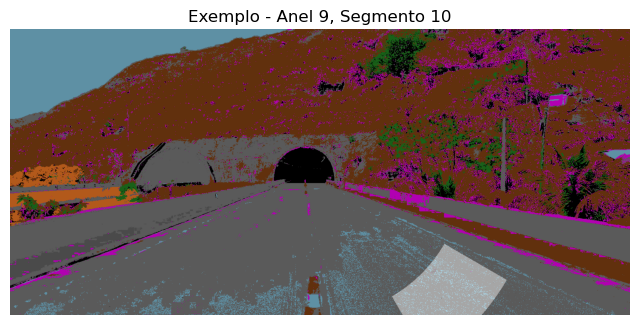

In [71]:
# Parâmetros do setor que você quer visualizar
anel_exemplo = 9        # anel de dentro para fora (0 = centro)
segmento_exemplo = 10
# segmento no sentido horário (1..num_setores)

# Calcular índice do setor
setor_exemplo = anel_exemplo * num_setores + (segmento_exemplo - 1)
setor_exemplo=13

# Criar máscara RGB e overlay
mask_rgb = np.dstack([setores[setor_exemplo]*255]*3)
overlay = cv2.addWeighted(img_colorizada, 0.7, mask_rgb, 0.3, 0)

# Visualizar
plt.figure(figsize=(8,8))
plt.imshow(overlay)
plt.title(f"Exemplo - Anel {anel_exemplo}, Segmento {segmento_exemplo}")
plt.axis("off")
plt.show()
